# Trying to use transfer learning for different numbers of agents, and compare performances

In [1]:
%matplotlib inline

In [2]:
import gym
import math
import random
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from collections import namedtuple
from itertools import count
from PIL import Image

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as T
from torch.autograd import Variable

# set up matplotlib
is_ipython = 'inline' in matplotlib.get_backend()
if is_ipython:
    from IPython import display

plt.ion()

# if gpu is to be used
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
from utils.ReplayMemory import * 
from utils.networks import *
from utils.agents import *
from utils.plotting import *
from utils.train_test_methods import *

from importlib import reload
import utils
reload(utils.ReplayMemory)
reload(utils.networks)
reload(utils.agents)
reload(utils.plotting)
reload(utils.train_test_methods)

<module 'utils.train_test_methods' from '/Users/zz/Documents/GT20F/7000/GNN_experiments/utils/train_test_methods.py'>

In [4]:
U_VELOCITY = 1
U_ACCELERATION = 2
O_VELOCITY = 1
O_ACCELERATION = 2

# Use the purple-pink pair (LA-uVel-oVel & RA-uVel-oVel) as example
input_type = U_VELOCITY
observe_type = O_VELOCITY

# Let's start with a larger environment to test out transfer learning
N = 100
env_ms = gym.make('ConsensusEnv:ConsensusContEnv-v0', N=N, dt=0.1, Delta=0.05,
              input_type=input_type, observe_type=observe_type).unwrapped
N = 10
env = gym.make('ConsensusEnv:ConsensusContEnv-v0', N=N, dt=0.1, Delta=0.05,
              input_type=input_type, observe_type=observe_type).unwrapped


In [15]:
# Load pre-trained models
agent5 = LearnerAgent(device, N, env.no, env.na, hidden)
agent7 = RewardAgent(device, N, env.no, env.na, hidden)
agent5.load_model('models/LearnerAgent_test3_LA-uVel-oVel')
agent7.load_model('models/RewardAgent_test3_RA-uVel-oVel')

Loading model from models/LearnerAgent_test3_LA-uVel-oVel
Loading model from models/RewardAgent_test3_RA-uVel-oVel


In [113]:
reload(utils.ReplayMemory)
reload(utils.networks)
reload(utils.agents)
reload(utils.plotting)
reload(utils.train_test_methods)
from utils.ReplayMemory import * 
from utils.networks import *
from utils.agents import *
from utils.plotting import *
from utils.train_test_methods import *


In [109]:
na = env.na
ns = env.nf
hidden = 32

num_episode=250#500
transfer_num_episode=101
test_interval=25#50
num_test=50
num_iteration=200
BATCH_SIZE=128*2
debug=False
num_sample=50

if input_type == U_ACCELERATION:
    action_space = [-env.a_max, env.a_max]
else:
    action_space = [-env.v_max, env.v_max]


In [ ]:
# Train the base network (100 agents)
N = 100
seed=202020

LA100_ms = LearnerAgent(device, N, env_ms.no, env_ms.na, hidden, action_range=action_space)
RA100_ms = RewardAgent(device, N, env_ms.no, env_ms.na, hidden)
RA100_ms_dc = RewardAgent(device, N, env_ms.no, env_ms.na, hidden)

LA100_hist = train(LA100_ms, env_ms, num_episode, test_interval, num_test, 
                   num_iteration, BATCH_SIZE, num_sample, action_space, debug, 
                   seed=seed, reward_mode=FUTURE_REWARD_NO)
RA100_hist = train(RA100_ms, env_ms, num_episode, test_interval, num_test, 
                   num_iteration, BATCH_SIZE, num_sample, action_space, debug, 
                   seed=seed, reward_mode=FUTURE_REWARD_NO)
RA100_hist_dc = train(RA100_ms_dc, env_ms, num_episode, test_interval, num_test, 
                   num_iteration, BATCH_SIZE, num_sample, action_space, debug, 
                   seed=seed, reward_mode=FUTURE_REWARD_YES)

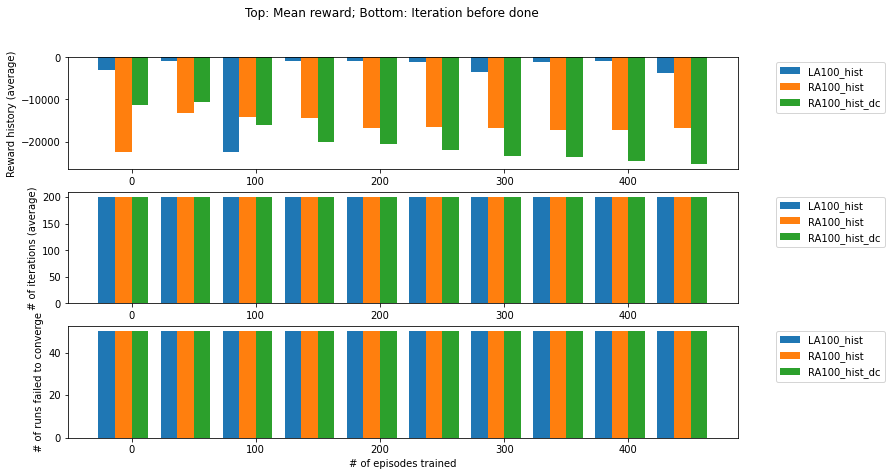

In [10]:
# Test the base network to make sure they work well, and have worked well
plot_reward_hist([LA100_hist, RA100_hist, RA100_hist_dc], test_interval, 
                 ['LA100_hist', 'RA100_hist', 'RA100_hist_dc'], 
                 log=False, num_iteration=num_iteration)

In [11]:
# If all goes well, save the weights
LA100_ms.save_model('LA100_master_agent_fail')
RA100_ms.save_model('RA100_master_agent_fail')
RA100_ms_dc.save_model('RA100_master_agent_discount_fail')

Saving model to models/LearnerAgent_LA100_master_agent_fail
Saving model to models/RewardAgent_RA100_master_agent_fail
Saving model to models/RewardAgent_RA100_master_agent_discount_fail


In [110]:
# Train the base network (32 agents because hidden layer is only that big)
N = 32
seed=32323

env_ms = gym.make('ConsensusEnv:ConsensusContEnv-v0', N=N, dt=0.1, Delta=0.05,
              input_type=input_type, observe_type=observe_type).unwrapped
LA32_ms = LearnerAgent(device, N, env_ms.no, env_ms.na, hidden, action_range=action_space)
RA32_ms = RewardAgent(device, N, env_ms.no, env_ms.na, hidden)
RA32_ms_dc = RewardAgent(device, N, env_ms.no, env_ms.na, hidden)

LA32_hist = train(LA32_ms, env_ms, 50, test_interval, num_test, 
                   num_iteration, BATCH_SIZE, num_sample, action_space, debug, 
                   seed=seed, reward_mode=FUTURE_REWARD_NO)
RA32_hist = train(RA32_ms, env_ms, num_episode, test_interval, num_test, 
                   num_iteration, BATCH_SIZE, num_sample, action_space, debug, 
                   seed=seed, reward_mode=FUTURE_REWARD_NO)
RA32_hist_dc = train(RA32_ms_dc, env_ms, num_episode, test_interval, num_test, 
                   num_iteration, BATCH_SIZE, num_sample, action_space, debug, 
                   seed=seed, reward_mode=FUTURE_REWARD_YES)

Test result at episode  0 : 
[10025103  3448951 14317730 17810848 30515044 15744048  7611381 22360682
 15551059 18704773 10225927 29029360  6447629 30250908 14150225 31010265
 16619632 20067306 15087696 18640795  6686279  5227273 28361251   650159
 13639980  6942385   357025 30836701  7141669  3635748 24254835  4946184
 13158597 12175803  5608033 23039089 15095406 23130042 30779517 21229703
 30162032  9644968  6587727 20470296 29011286 21645016  2239349  8392964
 10240275   540479]
Finished test  0  with  199 ; cumulative reward =  -11938.85467960648
Finished test  1  with  199 ; cumulative reward =  -12903.51114193211
Finished test  2  with  199 ; cumulative reward =  -12715.966088113668
Finished test  3  with  199 ; cumulative reward =  -18877.715012791512
Finished test  4  with  199 ; cumulative reward =  -14405.71108203522
Finished test  5  with  199 ; cumulative reward =  -16661.987449905613
Finished test  6  with  199 ; cumulative reward =  -32835.612076494974
Finished test  7  w

TypeError: __new__() missing 4 required positional arguments: 'state', 'action', 'next_state', and 'reward'

In [117]:
# RA32_hist += train(RA32_ms, env_ms, num_episode, test_interval, num_test, 
#                    num_iteration, BATCH_SIZE*4, num_sample, action_space, debug, 
#                    seed=seed, reward_mode=FUTURE_REWARD_NO)
RA32_hist_dc += train(RA32_ms_dc, env_ms, num_episode, test_interval, num_test, 
                   num_iteration, BATCH_SIZE*4, num_sample, action_space, debug, 
                   seed=seed, reward_mode=FUTURE_REWARD_YES)

Test result at episode  0 : 
[10025103  3448951 14317730 17810848 30515044 15744048  7611381 22360682
 15551059 18704773 10225927 29029360  6447629 30250908 14150225 31010265
 16619632 20067306 15087696 18640795  6686279  5227273 28361251   650159
 13639980  6942385   357025 30836701  7141669  3635748 24254835  4946184
 13158597 12175803  5608033 23039089 15095406 23130042 30779517 21229703
 30162032  9644968  6587727 20470296 29011286 21645016  2239349  8392964
 10240275   540479]
Finished test  0  with  199 ; cumulative reward =  -104245.16426693041
Finished test  1  with  199 ; cumulative reward =  -94186.75667228072
Finished test  2  with  199 ; cumulative reward =  -110666.63322627175
Finished test  3  with  199 ; cumulative reward =  -81832.78647662379
Finished test  4  with  199 ; cumulative reward =  -103553.31882498223
Finished test  5  with  199 ; cumulative reward =  -136128.72383654333
Finished test  6  with  199 ; cumulative reward =  -93391.21010484216
Finished test  7  w

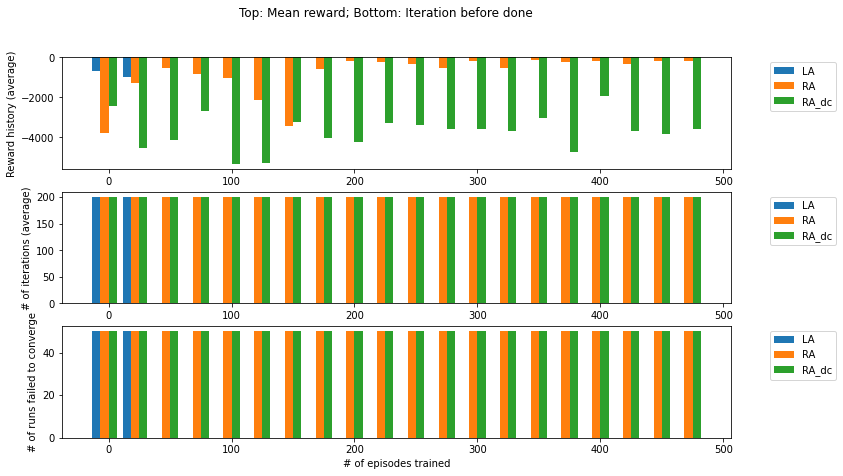

In [118]:
# Test the base network to make sure they work well, and have worked well
plot_reward_hist([LA32_hist, RA32_hist, RA32_hist_dc], test_interval, 
                 ['LA', 'RA', 'RA_dc'], 
                 log=False, num_iteration=num_iteration)

In [119]:
# If all goes well, save the weights
LA32_ms.save_model('LA32_master_agent')
RA32_ms.save_model('RA32_master_agent')
RA32_ms_dc.save_model('RA32_master_agent_discount')

Saving model to models/LearnerAgent_LA32_master_agent
Saving model to models/RewardAgent_RA32_master_agent
Saving model to models/RewardAgent_RA32_master_agent_discount


In [ ]:
# Train the base network (10 agents) for sanity check
N = 10
seed=202020

LA10_ms = LearnerAgent(device, N, env.no, env.na, hidden, action_range=action_space)
RA10_ms = RewardAgent(device, N, env.no, env.na, hidden)
RA10_ms_dc = RewardAgent(device, N, env.no, env.na, hidden)

LA10_hist = train(LA10_ms, env, num_episode, test_interval, num_test, 
                   num_iteration, BATCH_SIZE, num_sample, action_space, debug, 
                   seed=seed, reward_mode=FUTURE_REWARD_NO)
RA10_hist = train(RA10_ms, env, num_episode, test_interval, num_test, 
                   num_iteration, BATCH_SIZE, num_sample, action_space, debug, 
                   seed=seed, reward_mode=FUTURE_REWARD_NO)
RA10_hist_dc = train(RA10_ms_dc, env, num_episode, test_interval, num_test, 
                   num_iteration, BATCH_SIZE, num_sample, action_space, debug, 
                   seed=seed, reward_mode=FUTURE_REWARD_YES)

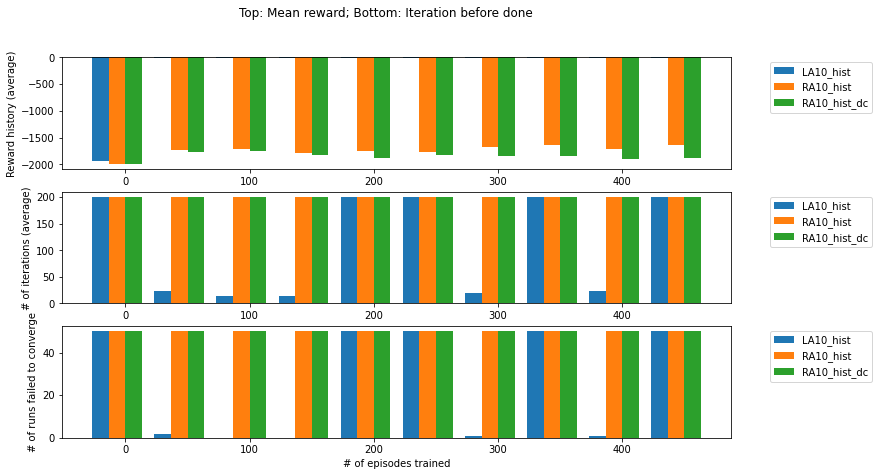

In [13]:
# Test the base network to make sure they work well, and have worked well
plot_reward_hist([LA10_hist, RA10_hist, RA10_hist_dc], test_interval, 
                 ['LA10_hist', 'RA10_hist', 'RA10_hist_dc'], 
                 log=False, num_iteration=num_iteration)

In [ ]:
# Additional training
RA10_hist += train(RA10_ms, env, num_episode, test_interval, num_test, 
                   num_iteration, BATCH_SIZE, num_sample, action_space, debug, 
                   seed=seed, reward_mode=FUTURE_REWARD_NO)
RA10_hist_dc += train(RA10_ms_dc, env, num_episode, test_interval, num_test, 
                   num_iteration, BATCH_SIZE, num_sample, action_space, debug, 
                   seed=seed, reward_mode=FUTURE_REWARD_YES)
plot_reward_hist([LA10_hist, RA10_hist, RA10_hist_dc], test_interval, 
                 ['LA10_hist', 'RA10_hist', 'RA10_hist_dc'], 
                 log=False, num_iteration=num_iteration)

In [11]:
# If all goes well, save the weights
LA10_ms.save_model('LA10_master_agent_fail')
RA10_ms.save_model('RA10_master_agent_fail')
RA10_ms_dc.save_model('RA10_master_agent_discount_fail')

Saving model to models/LearnerAgent_LA100_master_agent_fail
Saving model to models/RewardAgent_RA100_master_agent_fail
Saving model to models/RewardAgent_RA100_master_agent_discount_fail


In [ ]:
# Use the old agent network....... would it help at all???
reload(utils.ReplayMemory)
reload(utils.networks)
reload(utils.agents)
reload(utils.plotting)
reload(utils.train_test_methods)
from utils.ReplayMemory import * 
from utils.networks import *
from utils.agents import *
from utils.plotting import *
from utils.train_test_methods import *
N = 10
seed=202020

RA10_alt = RewardAgent(device, N, env.no, env.na, hidden)
RA10_alt_dc = RewardAgent(device, N, env.no, env.na, hidden)
                          
RA10_alt_hist = train(RA10_alt, env, num_episode, test_interval, num_test, 
                   num_iteration, BATCH_SIZE, num_sample, action_space, debug, 
                   seed=seed, reward_mode=FUTURE_REWARD_NO)
RA10_alt_hist_dc = train(RA10_alt_dc, env, num_episode, test_interval, num_test, 
                   num_iteration, BATCH_SIZE, num_sample, action_space, debug, 
                   seed=seed, reward_mode=FUTURE_REWARD_YES)
# Test the base network to make sure they work well, and have worked well
plot_reward_hist([LA10_hist, RA10_alt_hist, RA10_alt_hist_dc], test_interval, 
                 ['LA10_hist', 'RA10_hist', 'RA10_hist_dc'], 
                 log=False, num_iteration=num_iteration)

In [22]:
env_ms.N

100

In [213]:
# Test Reward tf gradient with more layers
reload(utils.networks)
reload(utils.agents)
reload(utils.train_test_methods)
from utils.networks import *
from utils.agents import *
from utils.train_test_methods import *

RApath = 'models/RewardAgent_RA32_master_agent'
prevN = 32
RAtest = RewardAgent(device, 10, env_list[1].no, env_list[1].na, hidden, prevN=prevN, load_path=RApath)

num_episode=2#500
test_interval=50
num_test=0#50
num_iteration=10#200
BATCH_SIZE=128
debug=False
num_sample=50

___ = train(RAtest, env_list[1], 
              num_episode, test_interval, num_test, num_iteration, BATCH_SIZE, num_sample, [-1,1], debug)

5th Last layer gradients after backward:  tensor(-36.8803)
4th Last layer gradients after backward:  tensor(0.6576)
3rd Last layer gradients after backward:  tensor(0.1212)
2nd Last layer gradients after backward:  tensor(2.4450)
Last     layer gradients after backward:  tensor(-1.0407)
5th Last layer gradients after backward:  tensor(-7.9261)
4th Last layer gradients after backward:  tensor(1.0088)
3rd Last layer gradients after backward:  tensor(0.0873)
2nd Last layer gradients after backward:  tensor(-0.0113)
Last     layer gradients after backward:  tensor(-0.2633)
5th Last layer gradients after backward:  tensor(0.)
4th Last layer gradients after backward:  tensor(0.)
3rd Last layer gradients after backward:  tensor(0.)
2nd Last layer gradients after backward:  tensor(0.)
Last     layer gradients after backward:  tensor(0.)
5th Last layer gradients after backward:  tensor(0.)
4th Last layer gradients after backward:  tensor(0.)
3rd Last layer gradients after backward:  tensor(0.)


In [124]:
reload(utils.networks)
reload(utils.agents)
reload(utils.train_test_methods)
from utils.networks import *
from utils.agents import *
from utils.train_test_methods import *

# Bulid environments with different number of agents
env_list = []
N_list = [5, 10, 20, 32, 50, 64]
for N_ in N_list:
    env_list.append(
        gym.make('ConsensusEnv:ConsensusContEnv-v0', N=N_, dt=0.1, Delta=0.05,
              input_type=input_type, observe_type=observe_type).unwrapped
    )

# Initialize agents for different number of agents and load weights
LApath = 'models/LearnerAgent_LA32_master_agent'
RApath = 'models/RewardAgent_RA32_master_agent'
prevN = 32
LA_list = []
RA_list = []
for i,N_ in enumerate(N_list):
    LA_list.append(
        LearnerAgent(device, N_, env_list[i].no, env_list[i].na, hidden, prevN=prevN, load_path=LApath)
    )
    RA_list.append(
        RewardAgent(device, N_, env_list[i].no, env_list[i].na, hidden, prevN=prevN, load_path=RApath)
    )

In [ ]:
# Train those agents one by one, I guess
LA_hists = []
RA_hists = []
for i,N_ in enumerate(N_list):
    LA_hists.append(
        train(LA_list[i], env_list[i], 
              transfer_num_episode, test_interval, num_test, num_iteration, BATCH_SIZE, num_sample, [-1,1], debug)
    )
    print("Finished training env with {0} agents for LA".format(N_))
    RA_hists.append(
        train(RA_list[i], env_list[i], 
              transfer_num_episode, test_interval, num_test, num_iteration, BATCH_SIZE, num_sample, [-1,1], debug)
    )
    print("Finished training env with {0} agents for RA".format(N_))

In [131]:
for i,N_ in enumerate(N_list):
    LA_list[i].save_model('tf_test3_N{0}_from_N32'.format(N_))
    RA_list[i].save_model('tf_test3_N{0}_from_N32'.format(N_))

Saving model to models/LearnerAgent_tf_test3_N5_from_N32
Saving model to models/RewardAgent_tf_test3_N5_from_N32
Saving model to models/LearnerAgent_tf_test3_N10_from_N32
Saving model to models/RewardAgent_tf_test3_N10_from_N32
Saving model to models/LearnerAgent_tf_test3_N20_from_N32
Saving model to models/RewardAgent_tf_test3_N20_from_N32
Saving model to models/LearnerAgent_tf_test3_N32_from_N32
Saving model to models/RewardAgent_tf_test3_N32_from_N32
Saving model to models/LearnerAgent_tf_test3_N50_from_N32
Saving model to models/RewardAgent_tf_test3_N50_from_N32
Saving model to models/LearnerAgent_tf_test3_N64_from_N32
Saving model to models/RewardAgent_tf_test3_N64_from_N32


In [52]:
for i,N_ in enumerate(N_list):
    LA_list[i].save_model('tf_test1_N{0}'.format(N_))
    RA_list[i].save_model('tf_test1_N{0}'.format(N_))

Saving model to models/LearnerAgent_tf_test1_N5
Saving model to models/RewardAgent_tf_test1_N5
Saving model to models/LearnerAgent_tf_test1_N20
Saving model to models/RewardAgent_tf_test1_N20
Saving model to models/LearnerAgent_tf_test1_N50
Saving model to models/RewardAgent_tf_test1_N50
Saving model to models/LearnerAgent_tf_test1_N100
Saving model to models/RewardAgent_tf_test1_N100
Saving model to models/LearnerAgent_tf_test1_N250
Saving model to models/RewardAgent_tf_test1_N250


In [ ]:
# Test those agents one by one, probably
LA_test_hists = []
RA_test_hists = []
num_test=20
for i,N_ in enumerate(N_list):
    LA_test_hists.append(
        plot_test(LA_list[i], env_list[i], fnames=['']*num_test,
            num_iteration=num_iteration, action_space=action_space, imdir='screencaps/')
    )
    print("Finished testnig env with {0} agents for LA".format(N_))
    RA_test_hists.append(
        plot_test(RA_list[i], env_list[i], fnames=['']*num_test,
            num_iteration=num_iteration, action_space=action_space, imdir='screencaps/')
    )
    print("Finished testing env with {0} agents for RA".format(N_))

In [175]:
# Compare transferred model weights with source model weights
print("Check LA.fc1")
for j in range(len(LA_list)):
    print(LA_list[j].net.ANlayers[1].weight.data)
print(agent5.net.fc1.weight.data)

print("Check LA.fc2")
for j in range(len(LA_list)):
    print(LA_list[j].net.ANlayers[2].weight.data)
print(agent5.net.fc2.weight.data)

print("Check LA.fc3")
for j in range(len(LA_list)):
    print(LA_list[j].net.ANlayers[3].weight.data)
print(agent5.net.fc3.weight.data)


print("Check RA.fc1")
for j in range(len(RA_list)):
    print(RA_list[j].net.RNlayers[1].weight.data)
print(agent7.net.fc1.weight.data)
print("Check RA.fc2")
for j in range(len(RA_list)):
    print(RA_list[j].net.RNlayers[2].weight.data)
print(agent7.net.fc2.weight.data)
print("Check RA.fc3")
for j in range(len(RA_list)):
    print(RA_list[j].net.RNlayers[3].weight.data)
print(agent7.net.fc3.weight.data)

Check LA.fc1
tensor([[ 0.0994, -0.1567, -0.1747,  ..., -0.2019, -0.2060, -0.0112],
        [-0.1185, -0.1307, -0.5236,  ...,  0.1757, -0.0508,  0.1060],
        [ 0.3451,  0.9522,  0.6599,  ..., -0.0824,  0.2609,  0.3099],
        ...,
        [ 0.2608,  0.0245, -0.0160,  ..., -0.1811, -0.1031, -0.0087],
        [-0.6982, -0.4603, -0.6139,  ..., -0.0215, -0.0372,  0.1413],
        [ 1.0285,  0.6622,  0.4584,  ...,  0.0253, -0.0794, -0.0819]])
tensor([[ 0.0994, -0.1567, -0.1747,  ..., -0.2019, -0.2060, -0.0112],
        [-0.1185, -0.1307, -0.5236,  ...,  0.1757, -0.0508,  0.1060],
        [ 0.3451,  0.9522,  0.6599,  ..., -0.0824,  0.2609,  0.3099],
        ...,
        [ 0.2608,  0.0245, -0.0160,  ..., -0.1811, -0.1031, -0.0087],
        [-0.6982, -0.4603, -0.6139,  ..., -0.0215, -0.0372,  0.1413],
        [ 1.0285,  0.6622,  0.4584,  ...,  0.0253, -0.0794, -0.0819]])
tensor([[ 0.0994, -0.1567, -0.1747,  ..., -0.2019, -0.2060, -0.0112],
        [-0.1185, -0.1307, -0.5236,  ...,  0.1757

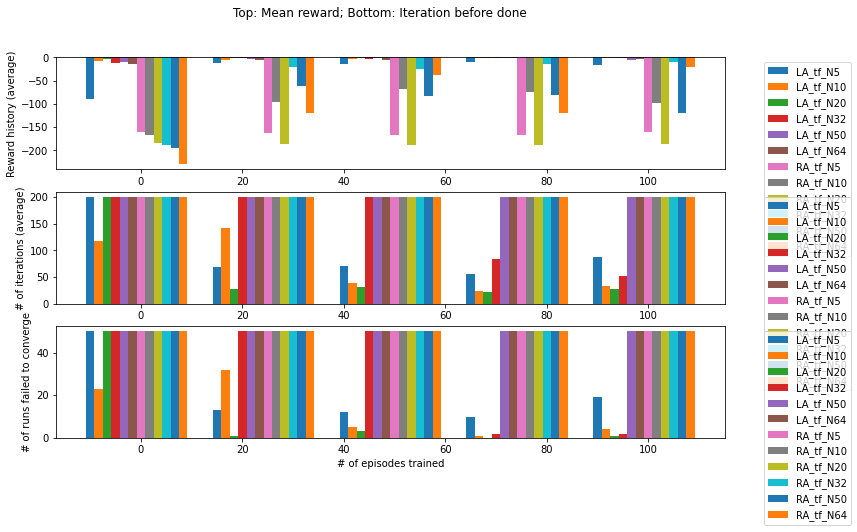

In [130]:
# Plot methods from the previous notebook. I should put it into a util file instead...
# Note that the plot method can now take # of agents into consideration.
# Here I'm squaring N to account for the increased number of possible agent pairs.
plot_reward_hist(LA_hists+RA_hists, test_interval, 
                 ['LA_tf_N{0}'.format(N_) for N_ in N_list] + ['RA_tf_N{0}'.format(N_) for N_ in N_list], 
                 log=False, num_iteration=num_iteration, N_list=[N for N in N_list]*2)

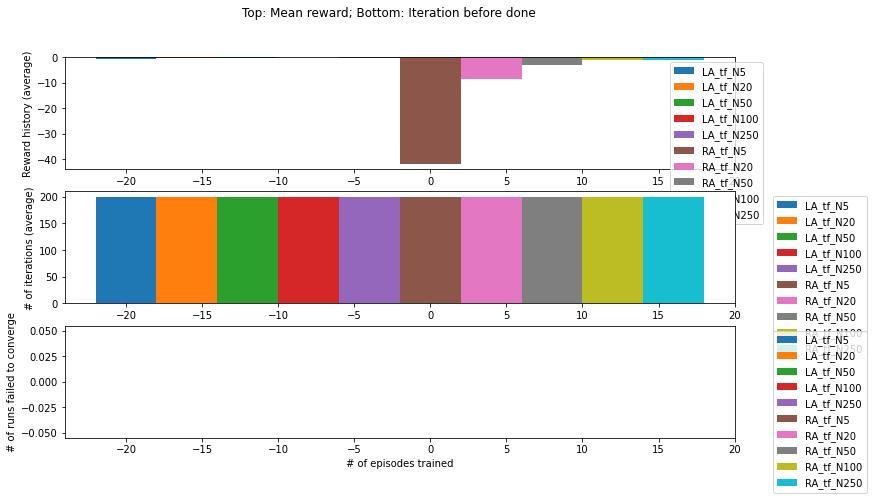

In [68]:
# Plot it for final test runs as well.?
plot_reward_hist([[la] for la in LA_test_hists]+[[ra] for ra in RA_test_hists], test_interval, 
                 ['LA_tf_N{0}'.format(N_) for N_ in N_list] + ['RA_tf_N{0}'.format(N_) for N_ in N_list], 
                 log=False, num_iteration=num_iteration, N_list=[N*N for N in N_list]*2)

In [70]:
# Now train them from scratch... This will take a while.
na = env.na
ns = env.nf
hidden = 32

num_episode=500
transfer_num_episode=51
test_interval=100
num_test=50
num_iteration=200
BATCH_SIZE=128
debug=False
num_sample=50

if input_type == U_ACCELERATION:
    action_space = [-env.a_max, env.a_max]
else:
    action_space = [-env.v_max, env.v_max]

N_list = [5,20,50,100] # 250 would take too long
LA_scratch_list = []
RA_scratch_list = []
for i,N_ in enumerate(N_list):
    LA_scratch_list.append(
        LearnerAgent(device, N_, env_list[i].no, env_list[i].na, hidden)
    )
    RA_scratch_list.append(
        RewardAgent(device, N_, env_list[i].no, env_list[i].na, hidden)
    )

In [ ]:
# Train those agents one by one, I guess
LA_scratch_hists = []
RA_scratch_hists = []
for i,N_ in enumerate(N_list):
    LA_scratch_hists.append(
        train(LA_scratch_list[i], env_list[i], 
              num_episode, test_interval, num_test, num_iteration, BATCH_SIZE, num_sample, [-1,1], debug)
    )
    print("Finished training env with {0} agents for LA".format(N_))
    RA_scratch_hists.append(
        train(RA_scratch_list[i], env_list[i], 
              num_episode, test_interval, num_test, num_iteration, BATCH_SIZE, num_sample, [-1,1], debug)
    )
    print("Finished training env with {0} agents for RA".format(N_))

In [ ]:
# You'll have to do additional trainings here, guaranteed...
num_episode = 500
additional_train_LA = [False, False, True, True, True]
additional_train_RA = [False, False, True, True, True]
for i,N_ in enumerate(N_list):
    if additional_train_LA[i]:
        LA_scratch_hists[i] += train(LA_scratch_list[i], env_list[i], 
                  num_episode, test_interval, num_test, num_iteration, BATCH_SIZE, num_sample, [-1,1], debug)
        print("Finished training env with {0} agents for LA".format(N_))
    if additional_train_RA[i]:
        RA_scratch_hists[i] += train(RA_scratch_list[i], env_list[i], 
                  num_episode, test_interval, num_test, num_iteration, BATCH_SIZE, num_sample, [-1,1], debug)
        print("Finished training env with {0} agents for RA".format(N_))

In [72]:
for i,N_ in enumerate(N_list):
    LA_scratch_list[i].save_model('fs_test1_N{0}'.format(N_))
    RA_scratch_list[i].save_model('fs_test1_N{0}'.format(N_))

Saving model to models/LearnerAgent_fs_test1_N5
Saving model to models/RewardAgent_fs_test1_N5
Saving model to models/LearnerAgent_fs_test1_N20
Saving model to models/RewardAgent_fs_test1_N20
Saving model to models/LearnerAgent_fs_test1_N50
Saving model to models/RewardAgent_fs_test1_N50
Saving model to models/LearnerAgent_fs_test1_N100
Saving model to models/RewardAgent_fs_test1_N100


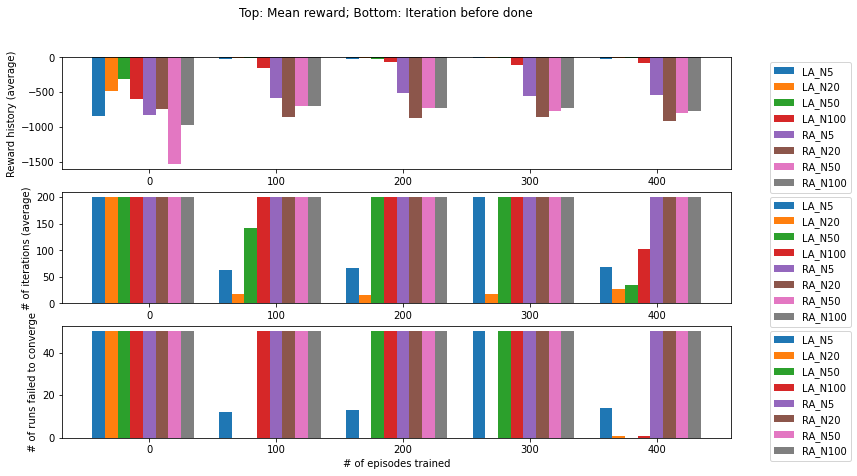

In [78]:
plot_reward_hist(LA_scratch_hists+RA_scratch_hists, test_interval, 
                 ['LA_N{0}'.format(N_) for N_ in N_list] + ['RA_N{0}'.format(N_) for N_ in N_list], 
                 log=False, num_iteration=num_iteration, N_list=[N for N in N_list]*2)

In [ ]:
# Test those agents one by one, probably
LA_scratch_test_hists = []
RA_scratch_test_hists = []
for i,N_ in enumerate(N_list):
    LA_scratch_test_hists.append(
        plot_test(LA_scratch_list[i], env_list[i], fnames=['']*num_test,
            num_iteration=num_iteration, action_space=action_space, imdir='screencaps/')
    )
    print("Finished testnig env with {0} agents for LA".format(N_))
    RA_scratch_test_hists.append(
        plot_test(RA_scratch_list[i], env_list[i], fnames=['']*num_test,
            num_iteration=num_iteration, action_space=action_space, imdir='screencaps/')
    )
    print("Finished testing env with {0} agents for RA".format(N_))

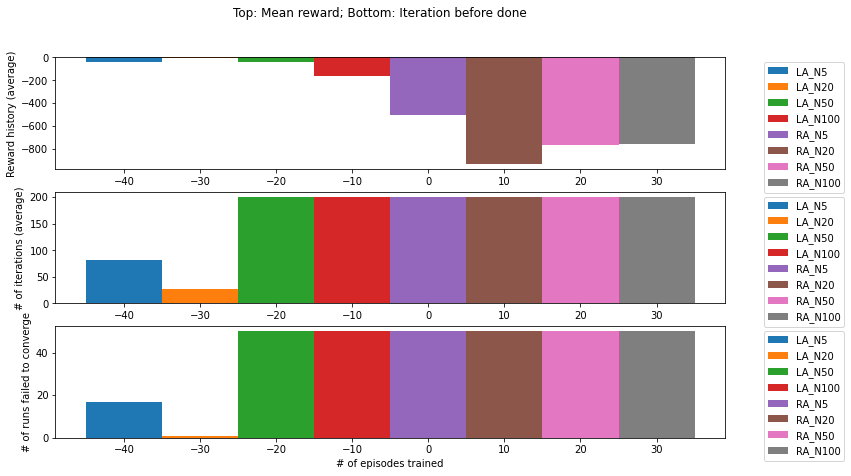

In [79]:
plot_reward_hist([[l] for l in LA_scratch_test_hists] + [[r] for r in RA_scratch_test_hists], test_interval, 
                 ['LA_N{0}'.format(N_) for N_ in N_list] + ['RA_N{0}'.format(N_) for N_ in N_list], 
                 log=False, num_iteration=num_iteration, N_list=[N for N in N_list]*2)

## Try out Actor-Critic

In [ ]:
# Test out Actor-Critic methods. Note that tuning parameters might be required.
reload(utils.ReplayMemory)
reload(utils.networks)
reload(utils.agents)
reload(utils.plotting)
from utils.ReplayMemory import * 
from utils.networks import *
from utils.agents import *
from utils.plotting import *

num_episode=250
test_interval=50
num_test=25
num_iteration=200
BATCH_SIZE=128
debug=False
num_sample=50

N_list = [5,20,50,100] # 250 would take too long
AC1_list = []
for i,N_ in enumerate(N_list):
    AC1_list.append(
        AC1Agent(device, N_, env_list[i].no, env_list[i].na, hidden)
    )
AC1_hist = []
for i,N_ in enumerate(N_list):
    AC1_hist.append(
        train(AC1_list[i], env_list[i], 
              num_episode, test_interval, num_test, num_iteration, BATCH_SIZE, num_sample, [-1,1], debug)
    )
    print("Finished training env with {0} agents for AC".format(N_))
AC1_test_hist = []
for i,N_ in enumerate(N_list):
    AC1_test_hist.append(
        plot_test(AC1_list[i], env_list[i], fnames=['']*num_test,
            num_iteration=num_iteration, action_space=action_space, imdir='screencaps/')
    )
    print("Finished testnig env with {0} agents for AC".format(N_))

In [ ]:
plot_reward_hist(AC1_hist, test_interval, 
                 ['AC1_N{0}'.format(N_) for N_ in N_list], 
                 log=False, num_iteration=num_iteration, N_list=[N for N in N_list]*2)

In [ ]:
plot_reward_hist([[l] for l in AC1_test_hist], test_interval, ['AC1_N{0}'.format(N_) for N_ in N_list], 
                 log=False, num_iteration=num_iteration, N_list=[N for N in N_list]*2)

In [ ]:
# Test out Actor-Critic methods. Note that tuning parameters might be required.
reload(utils.ReplayMemory)
reload(utils.networks)
reload(utils.agents)
reload(utils.plotting)
reload(utils.train_test_methods)
from utils.ReplayMemory import * 
from utils.networks import *
from utils.agents import *
from utils.plotting import *
from utils.train_test_methods import *

num_episode=500#1#500
test_interval=50
num_test=50#0#50
num_iteration=200#10#200
BATCH_SIZE=128
debug=False
num_sample=50

# N_list = [5,20,50,100] # 250 would take too long
AC2_list = []
for i,N_ in enumerate(N_list[:4]):
    AC2_list.append(
        AC2Agent(device, N_, env_list[i].no, env_list[i].na, hidden, 
                 learning_rateA=0.01, learning_rateC=0.02)
    )
# AC2_list.append(
#     AC2Agent(device, 10, env.no, env.na, hidden)
# )

AC2_hist = []
for i,N_ in enumerate(N_list[:4]):
    AC2_hist.append(
        train(AC2_list[i], env_list[i], 
              num_episode, test_interval, num_test, num_iteration, BATCH_SIZE, num_sample, [-1,1], debug)
    )
    print("Finished training env with {0} agents for AC".format(N_))
# AC2_hist.append(
#     train(AC2_list[-1], env, 
#           num_episode, test_interval, num_test, num_iteration, BATCH_SIZE, num_sample, [-1,1], debug)
#     )

AC2_test_hist = []
for i,N_ in enumerate(N_list[:4]):
    AC2_test_hist.append(
        plot_test(AC2_list[i], env_list[i], fnames=['']*num_test,
            num_iteration=num_iteration, action_space=action_space, imdir='screencaps/',debug=debug)
    )
    print("Finished testnig env with {0} agents for AC".format(N_))
# AC2_test_hist.append(
#     plot_test(AC2_list[-1], env, fnames=['']*num_test,
#         num_iteration=num_iteration, action_space=action_space, imdir='screencaps/',debug=debug)
# )

In [148]:

AC2_list.append(
    AC2Agent(device, 10, env.no, env.na, hidden)
)
AC2_hist.append(
    train(AC2_list[-1], env, 
          num_episode, test_interval, num_test, num_iteration, BATCH_SIZE, num_sample, [-1,1], debug)
    )

AC2_test_hist = []
for i,N_ in enumerate(N_list):
    AC2_test_hist.append(
        plot_test(AC2_list[i], env_list[i], fnames=['']*num_test,
            num_iteration=num_iteration, action_space=action_space, imdir='screencaps/',debug=debug)
    )
    print("Finished testnig env with {0} agents for AC".format(N_))
AC2_test_hist.append(
    plot_test(AC2_list[-1], env, fnames=['']*num_test,
        num_iteration=num_iteration, action_space=action_space, imdir='screencaps/',debug=debug)
)

Test result at episode  0 : 
[11670944 22851341 10552915 13809098 24555918 15079090 14325343 23364668
 16339895 10500288 21806113 28963676  3195980  5124537 21684480 27241941
 22214581 11942504  6678488 11761867 28256092 20032965 22314105 12578549
 22325054 11040014 10526721    20057 28818431 26177918  6343697 25840821
 26960842 19284645 23850149 26106426 29453823 24683498 29858540 10862315
  1947615 21103977 24768013  3670832 28661599 25995140  8296426 14124755
 18612453  6946400]
Finished test  0  with  199 ; cumulative reward =  -19366.41760636126
Finished test  1  with  199 ; cumulative reward =  -19702.359712801204
Finished test  2  with  199 ; cumulative reward =  -19255.301098675674
Finished test  3  with  199 ; cumulative reward =  -19407.06504419061
Finished test  4  with  199 ; cumulative reward =  -19666.36647291335
Finished test  5  with  199 ; cumulative reward =  -19319.980644114938
Finished test  6  with  199 ; cumulative reward =  -19684.669430858765
Finished test  7  w

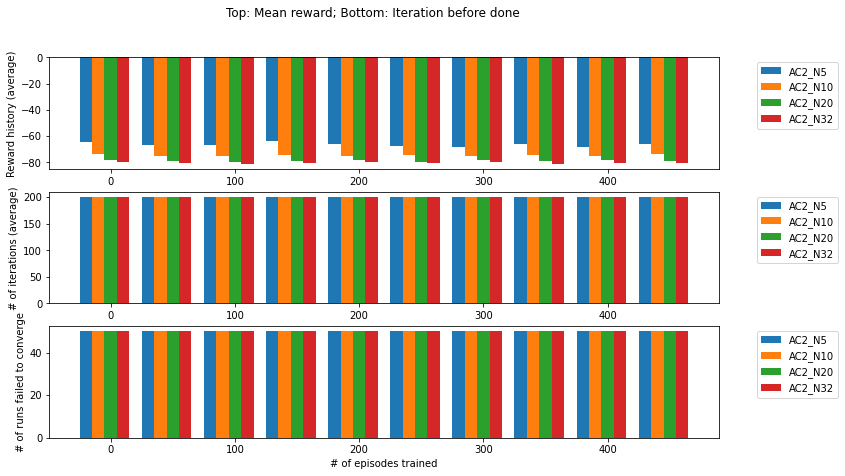

In [138]:
# plot_reward_hist(AC2_hist, test_interval, 
#                  ['AC2_N{0}'.format(N_) for N_ in N_list]+['AC2_N10'], 
#                  log=False, num_iteration=num_iteration, N_list=([np.sqrt(N) for N in N_list]+[np.sqrt(10)])*2)
plot_reward_hist(AC2_hist, test_interval, 
                 ['AC2_N{0}'.format(N_) for N_ in N_list[:4]], 
                 log=False, num_iteration=num_iteration, N_list=([N for N in N_list[:4]]))

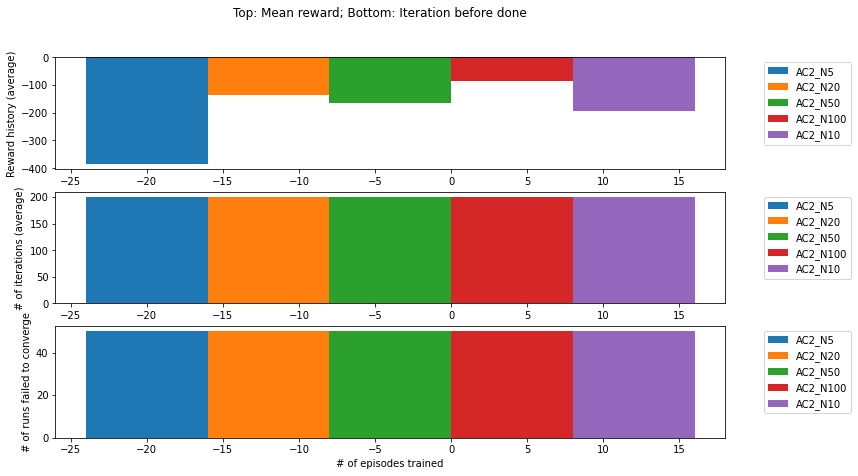

In [150]:
plot_reward_hist([[l] for l in AC2_test_hist], test_interval, 
                 ['AC2_N{0}'.format(N_) for N_ in N_list]+['AC2_N10'], 
                 log=False, num_iteration=num_iteration, N_list=([N for N in N_list]+[10])*2)

In [187]:
# Test out Actor-Critic methods. Note that tuning parameters might be required.
reload(utils.ReplayMemory)
reload(utils.networks)
reload(utils.agents)
reload(utils.plotting)
reload(utils.train_test_methods)
from utils.ReplayMemory import * 
from utils.networks import *
from utils.agents import *
from utils.plotting import *
from utils.train_test_methods import *

num_episode=2#500#1#500
test_interval=50
num_test=0#50#0#50
num_iteration=10#200#10#200
BATCH_SIZE=128
debug=False
num_sample=50

AC2_list_exp = []
for i,N_ in enumerate([5,10]):
    AC2_list_exp.append(
#         AC2Agent(device, N_, env_list[i].no, env_list[i].na, hidden, 
#                  learning_rateA=0.01, learning_rateC=0.02)
#         AC3Agent(device, N_, env_list[i].no, env_list[i].na, hidden, 
#                  learning_rateA=0.01, learning_rateC=0.02)
        DDPGAgent(device, N_, env_list[i].no, env_list[i].na, hidden)
    )

AC2_hist_exp = []
for i,N_ in enumerate([5,10]):
    AC2_hist_exp.append(
        train(AC2_list_exp[i], env_list[i], 
              num_episode, test_interval, num_test, num_iteration, BATCH_SIZE, num_sample, [-1,1], debug, 
                   seed=seed, reward_mode=FUTURE_REWARD_YES_NORMALIZE)
#                    seed=seed, reward_mode=FUTURE_REWARD_YES)
    )
    print("Finished training env with {0} agents for AC".format(N_))

AC2_test_hist_exp = []
for i,N_ in enumerate([5,10]):
    AC2_test_hist_exp.append(
        plot_test(AC2_list_exp[i], env_list[i], fnames=['']*num_test,
            num_iteration=num_iteration, action_space=action_space, imdir='screencaps/',debug=debug)
    )
    print("Finished testnig env with {0} agents for AC".format(N_))


Test result at episode  0 : 
[]
Last  layer Critic gradients after backward:  tensor(4.3827e-05)
Mid   layer Critic gradients after backward:  tensor(0.0004)
Front layer Critic gradients after backward:  tensor(-0.0423)
Last  layer Actor gradients after backward:  tensor(-4.1860e-07)
Mid   layer Actor gradients after backward:  tensor(-3.7676e-06)
Front layer Actor gradients after backward:  tensor(-0.0002)
Last  layer Critic gradients after backward:  tensor(-0.0029)
Mid   layer Critic gradients after backward:  tensor(-0.0070)
Front layer Critic gradients after backward:  tensor(-0.2248)
Last  layer Actor gradients after backward:  tensor(6.2993e-07)
Mid   layer Actor gradients after backward:  tensor(4.1447e-05)
Front layer Actor gradients after backward:  tensor(-0.0260)
Last  layer Critic gradients after backward:  tensor(0.0005)
Mid   layer Critic gradients after backward:  tensor(-0.0002)
Front layer Critic gradients after backward:  tensor(-0.0233)
Last  layer Actor gradients a

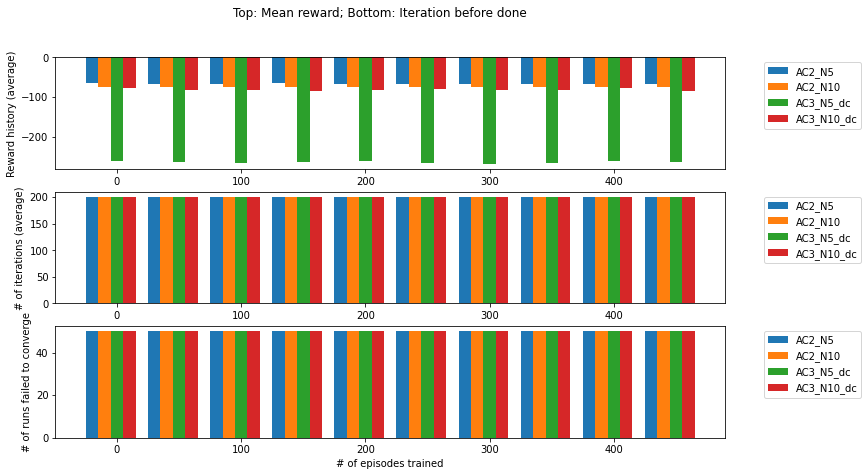

In [175]:
plot_reward_hist(AC2_hist[:2]+AC2_hist_exp, test_interval, 
                 ['AC2_N5', 'AC2_N10', 'AC3_N5_dc', 'AC3_N10_dc'], 
                 log=False, num_iteration=num_iteration, N_list=[5,10,5,10])

In [176]:
AC2_list_exp[0].save_model("AC3_messingaround_N5")
AC2_list_exp[1].save_model("AC3_messingaround_N10")

Saving model to models/AC3Agent_AC3_messingaround_N5


AttributeError: 'AC3Agent' object has no attribute 'net'

In [143]:
AC2_list_exp[0].netA.ANlayers[0].weight

Parameter containing:
tensor([[-0.2855, -0.2457,  0.0090,  0.2823,  0.1015,  0.2622,  0.2479, -0.2081,
          0.1121,  0.0547, -0.0321, -0.2494,  0.2286,  0.1899, -0.1905,  0.2220,
         -0.2990,  0.1382,  0.0577, -0.2978],
        [ 0.1818,  0.3177,  0.0990, -0.0713,  0.2923, -0.2076, -0.1309, -0.2518,
          0.0401,  0.2116,  0.0715,  0.2010, -0.0217,  0.0785,  0.0241, -0.2149,
          0.0521, -0.0309, -0.0160, -0.1668],
        [ 0.0923,  0.2273,  0.0282, -0.0645, -0.1931,  0.1030,  0.1010,  0.1960,
         -0.2025, -0.2188,  0.0718,  0.1032, -0.1387,  0.0970, -0.0943, -0.0373,
          0.0060, -0.0950, -0.1186,  0.0318],
        [-0.0133,  0.2836,  0.0913,  0.1001, -0.2200,  0.2479, -0.0769,  0.0552,
          0.0686,  0.1209, -0.0939,  0.1193, -0.1147, -0.1841, -0.0352, -0.0784,
          0.0959, -0.2980,  0.0160,  0.1295],
        [-0.0503,  0.2776,  0.1497, -0.0673,  0.0848,  0.1827,  0.1975, -0.2628,
          0.1921, -0.0085, -0.1338, -0.0373, -0.1218,  0.0169, -0

### DDPG

In [ ]:
reload(utils.agents)
from utils.agents import *

num_episode=500
test_interval=50
num_test=50
num_iteration=200
BATCH_SIZE=128
debug=False
num_sample=50

# Do DDPG
DDPG_list = []
for i,N_ in enumerate(N_list):
    DDPG_list.append(
        DDPGAgent(device, N_, env_list[i].no, env_list[i].na, hidden)
    )
DDPG_list.append(
    DDPGAgent(device, 10, env.no, env.na, hidden)
)

DDPG_hist = []
for i,N_ in enumerate(N_list):
    DDPG_hist.append(
        train(DDPG_list[i], env_list[i], 
              num_episode, test_interval, num_test, num_iteration, BATCH_SIZE, num_sample, [-1,1], debug)
    )
    print("Finished training env with {0} agents for AC".format(N_))
DDPG_hist.append(
    train(DDPG_list[-1], env, 
          num_episode, test_interval, num_test, num_iteration, BATCH_SIZE, num_sample, [-1,1], debug)
)
    
DDPG_test_hist = []
for i,N_ in enumerate(N_list):
    DDPG_test_hist.append(
        plot_test(DDPG_list[i], env_list[i], fnames=['']*num_test,
            num_iteration=num_iteration, action_space=action_space, imdir='screencaps/', debug=debug)
    )
    print("Finished testnig env with {0} agents for AC".format(N_))
DDPG_test_hist.append(
    plot_test(DDPG_list[-1], env, fnames=['']*num_test,
        num_iteration=num_iteration, action_space=action_space, imdir='screencaps/', debug=debug)
)

In [137]:

DDPG_test_hist = []
for i,N_ in enumerate(N_list):
    DDPG_test_hist.append(
        plot_test(DDPG_list[i], env_list[i], fnames=['']*num_test,
            num_iteration=num_iteration, action_space=action_space, imdir='screencaps/', debug=debug)
    )
    print("Finished testnig env with {0} agents for AC".format(N_))
DDPG_test_hist.append(
    plot_test(DDPG_list[-1], env, fnames=['']*num_test,
        num_iteration=num_iteration, action_space=action_space, imdir='screencaps/', debug=debug)
)

Finished episode  0  with  199 ;
cumulative reward =  -9837.671626131085
Finished episode  1  with  199 ;
cumulative reward =  -10391.991220207801
Finished episode  2  with  199 ;
cumulative reward =  -9945.994149509303
Finished episode  3  with  199 ;
cumulative reward =  -10170.38445060866
Finished episode  4  with  199 ;
cumulative reward =  -10225.054628529968
Finished episode  5  with  199 ;
cumulative reward =  -9405.984521719145
Finished episode  6  with  199 ;
cumulative reward =  -10072.129719639854
Finished episode  7  with  199 ;
cumulative reward =  -10441.678299420599
Finished episode  8  with  199 ;
cumulative reward =  -10411.612683652058
Finished episode  9  with  199 ;
cumulative reward =  -10032.283517569784
Finished episode  10  with  199 ;
cumulative reward =  -9586.257039199816
Finished episode  11  with  199 ;
cumulative reward =  -9892.78461986566
Finished episode  12  with  199 ;
cumulative reward =  -10123.28956565129
Finished episode  13  with  199 ;
cumulativ

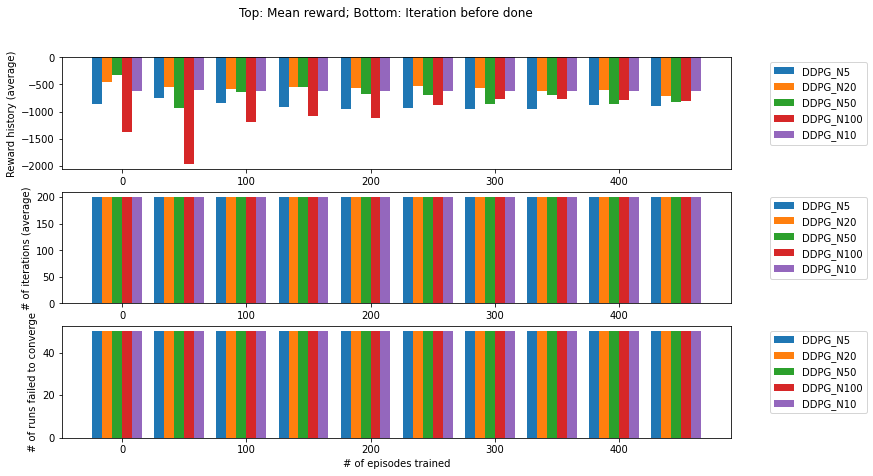

In [154]:
plot_reward_hist(DDPG_hist, test_interval, 
                 ['DDPG_N{0}'.format(N_) for N_ in N_list]+['DDPG_N10'], 
                 log=False, num_iteration=num_iteration, N_list=([np.sqrt(N) for N in N_list]+[np.sqrt(10)])*2)

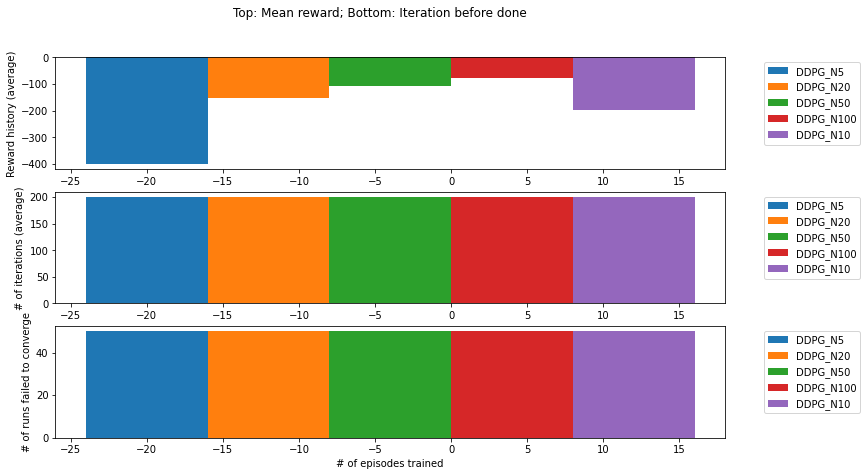

In [140]:
plot_reward_hist([[l] for l in DDPG_test_hist], test_interval, 
                 ['DDPG_N{0}'.format(N_) for N_ in N_list]+['DDPG_N10'], 
                 log=False, num_iteration=num_iteration, N_list=([N for N in N_list]+[10])*2)

In [151]:

def save_model(agent, suffix="", agent_path=None):
    if not os.path.exists('models/'):
        os.makedirs('models/')

    if len(suffix) <= 0:
        suffix = datetime.now().strftime('%Y_%m_%d_%H_%M_%S')
    if agent_path is None:
        agent_path = "models/{}_{}".format(agent.name, suffix)
    print('Saving model to {}'.format(agent_path))
    torch.save(agent.netA.state_dict(), agent_path+"_A")
    torch.save(agent.netC.state_dict(), agent_path+"_C")
    
for i,N_ in enumerate(N_list+[10]):
    save_model(AC2_list[i],'AC2_test2_N{0}'.format(N_))
    
def save_model(agent, suffix="", agent_path=None):
    if not os.path.exists('models/'):
        os.makedirs('models/')

    if len(suffix) <= 0:
        suffix = datetime.now().strftime('%Y_%m_%d_%H_%M_%S')
    if agent_path is None:
        agent_path = "models/{}_{}".format(agent.name, suffix)
    print('Saving model to {}'.format(agent_path))
    torch.save(agent.netA.state_dict(), agent_path+"_A")
    torch.save(agent.netC.state_dict(), agent_path+"_C")
    torch.save(agent.netAT.state_dict(), agent_path+"_AT")
    torch.save(agent.netCT.state_dict(), agent_path+"_CT")
    
for i,N_ in enumerate(N_list+[10]):
    save_model(DDPG_list[i],'DDPG_test2_N{0}'.format(N_))

Saving model to models/AC2Agent_AC2_test2_N5
Saving model to models/AC2Agent_AC2_test2_N20
Saving model to models/AC2Agent_AC2_test2_N50
Saving model to models/AC2Agent_AC2_test2_N100
Saving model to models/AC2Agent_AC2_test2_N10
Saving model to models/DDPGAgent_DDPG_test2_N5
Saving model to models/DDPGAgent_DDPG_test2_N20
Saving model to models/DDPGAgent_DDPG_test2_N50
Saving model to models/DDPGAgent_DDPG_test2_N100
Saving model to models/DDPGAgent_DDPG_test2_N10


### Play around with the gradient agent

In [81]:
# Play around with the gradient agent
N = 10
GA = GradientAgent(device, 10, ns, hidden)
GA.load_model('models/GradientAgent_test3_GA')

Loading model from models/GradientAgent_test3_GA


In [168]:
# Test model
class GradientAgentTest(BaseAgent):
    def __init__(self, device, N, ns=2, hidden=24, action_range=[-1,1], learning_rate=0.01, centralized=False):
        super().__init__(device, N)
        self.centralized = centralized
        if centralized:
            pass
        else:
            self.net = EnergyNet(N, 2, hidden)
        self.optimizer = torch.optim.RMSprop(self.net.parameters(), lr=learning_rate)
        self.needsExpert = True
        self.name = 'GradientAgentTest'
        self.range = action_range[1] - action_range[0]
        self.offset = 0.5*(action_range[0]+action_range[1])
        self.na = 2
    
    def getNextState(self, observed_state, action, dt=0.01):
        # Input: observed_state is a (M,2+,N) array, and action is (M,2). Each agent corresponds to a row.
        # Output: Supposedly, a (M,2,N) array that contains the expected new observed state.
        # Right now we're manually giving the agent a sense of its own dynamics with velocity input (single integrator)...
        # Hopefully it could go automatically soon.
        # Limitation: Doens't know if 0 means "not observed" or "already together". By default we assume the first. 
        # Thus, we first get a M*N matrix that records the neighbor information
        M,_,N = observed_state.shape
        is_neighbor = np.zeros((M,N))
        is_neighbor[ (observed_state[:,0,:]!=0) & (observed_state[:,1,:]!=0) ] = 1
        # Next, find the new relative distances based on the action. Assuming action means velocity, and we use a small dt.
        new_dists = observed_state[:,:2,:] - dt * action.reshape(M,2,1) # Broadcast action (M,2) to (M,2,N)
        # Filter out unobserved states
        new_dists *= is_neighbor.reshape(M,1,N)
        return new_dists
    
    def getEnergy(self, observed_state):
        # This is the expert that finds the energy function for each agent, but shhh don't let the rest know
        # Input: observed_state, expecting shape to be (N,no,N), as per the current environment, and be full of distance norms
        # Output: Probably (N,1), one for each agent. Let's make it only dependent on position for now; use velocity later.
        sum_dists = np.sum(np.linalg.norm(observed_state[:,:2,:], ord=2, axis=1), axis=1)
        print("Energy function says: ", sum_dists)
        return sum_dists
    
    # Picks an action based on given state.
    def select_action(self, state, **kwargs):
        # Input shape: state has shape (ns,N)
        with torch.no_grad():
            # Find gradients in both action space directions
            dt = 0.01
            da = 0.1
            sample_ax1p = self.getNextState(state.view(1,-1,self.N).detach().numpy(), np.array([[da,0]]).astype('float32'), dt) # Now shape: (1,2,N)
            sample_ax1n = self.getNextState(state.view(1,-1,self.N).detach().numpy(), np.array([[-da,0]]).astype('float32'), dt)
            sample_ax1p = self.net(torch.from_numpy(sample_ax1p)).squeeze().detach().numpy()
            sample_ax1n = self.net(torch.from_numpy(sample_ax1n)).squeeze().detach().numpy()
            sample_ax2p = self.net(
                torch.from_numpy(self.getNextState(state.view(1,-1,self.N).detach().numpy(), 
                                np.array([[0,da]]).astype('float32'), dt))).squeeze().detach().numpy()
            sample_ax2n = self.net(
                torch.from_numpy(self.getNextState(state.view(1,-1,self.N).detach().numpy(), 
                                np.array([[0,-da]]).astype('float32'), dt))).squeeze().detach().numpy()
            print("Action-induced values in each direction: \n", sample_ax1p,sample_ax1n, sample_ax2p,sample_ax2n)
            # Calculate approximate gradient
            action_dir = np.array([(sample_ax1p-sample_ax1n), (sample_ax2p-sample_ax2n)])*2/da/dt
#             print(action_dir)
            return np.clip(action_dir, -1,1)
    
    # Steps over gradients from memory replay
    def optimize_model(self, batch, **kwargs):
        B = kwargs.get('B', len(batch))
        # This class would assume that the optimal action is stored in batch input
        state_batch = torch.cat(batch.state)
        
        # Find loss & optimize the model
        self.net.train() 
        pred_energy = self.net(state_batch.view(B, -1, self.N)[:,:2,:]).squeeze() # Input shape should be (B,no,N) and output be (B,1)
        energy = torch.from_numpy(self.getEnergy(state_batch.view(B, -1, self.N).detach().numpy()))
        print("Actual energy = ", energy, " vs predicted energy = ", pred_energy)

        self.optimizer.zero_grad()
        loss = torch.nn.functional.mse_loss(energy, pred_energy)
        print(loss)
        loss.backward()
        self.optimizer.step()


In [169]:
def train_gradient(agent, env, num_episode=50, test_interval=25, num_test=20, num_iteration=200, 
          BATCH_SIZE=128, num_sample=50, action_space=[-1,1], debug=True, memory=None, seed=2020,
          update_mode=UPDATE_PER_EPISODE, reward_mode=FUTURE_REWARD_NO, gamma=0.99):
    test_hists = []
    steps = 0
    if memory is None:
        memory = ReplayMemory(1000 * env.N)
    
    # Values that would be useful
    N = env.N
    # Note that the seed only controls the numpy random, which affects the environment.
    # To affect pytorch, refer to further documentations: https://github.com/pytorch/pytorch/issues/7068
    np.random.seed(seed)
    test_seeds = np.random.randint(0, 5392644, size=(num_episode // test_interval)+1)

    for e in range(num_episode):
        steps = 0
        state = env.reset()
        state = torch.from_numpy(state).float()
        state = Variable(state)

        # Train History
        state_pool = []
        action_pool = []
        reward_pool = []
        next_state_pool = []

        for t in range(num_iteration):
            # agent.net.train()
            agent.set_train(True)
            # Try to pick an action, react, and store the resulting behavior in the pool here
            actions = []
            for i in range(N):
                action = agent.select_action(state[i], **{
                    'steps_done':t, 'num_sample':50, 'action_space':action_space
                })
                actions.append(action)
            action = np.array(actions).T # Shape would become (2,N)
            print("Agent's choice: ", action)

            next_state, reward, done, _ = env.step(action)
            print("After taking action ", action, " at state ", state, " with shape ", state.shape, ": ")
            print("True next state: ", next_state, "\n with shape = ", next_state.shape)
            print("Predicted next state: ", agent.getNextState(
                state.detach().numpy(), action, env.dt
            ))
            next_state = Variable(torch.from_numpy(next_state).float()) # The float() probably avoids bug in net.forward()
            action = action.T # Turn shape back to (N,2)

            if agent.needsExpert:
                # If we need to use expert input during training, then we consult it and get the best action for this state
                actions = env.controller()
                action = actions.T # Shape should already be (2,N), so we turn it into (N,2)
                print("In comparison, environment best action: ", action)
            
            if reward_mode == FUTURE_REWARD_NO:
                # Push everything directly inside if we don't use future discounts
                for i in range(N):
                    memory.push(state[i], action[i], next_state[i], reward[i])
            else:
                # Store and push them outside the loop
                state_pool.append(state)
                action_pool.append(action)
                reward_pool.append(reward)
                next_state_pool.append(next_state)
            
            state = next_state
            steps += 1
            
            if done:
                print("Took ", t, " steps to converge")
                break
        
        if reward_mode == FUTURE_REWARD_YES:
            for j in range(len(reward)):
                if j > 0:
                    reward_pool[-j-1] += gamma * reward_pool[-j]
                for i in range(N):
                    memory.push(state_pool[-j-1][i], action_pool[-j-1][i], 
                                next_state_pool[-j-1][i], reward_pool[-j-1][i])
                
        # Update 1028: Moved this training step outside the loop
        if len(memory) >= BATCH_SIZE:
            transitions = memory.sample(BATCH_SIZE)
            batch = Transition(*zip(*transitions))
            agent.optimize_model(batch, **{'B':BATCH_SIZE})
            
        if e % test_interval == 0:
            print("Test result at episode ", e, ": ")
            test_hist = test(agent, env, num_test, num_iteration, num_sample, action_space, 
                             seed=test_seeds[int(e/test_interval)], debug=debug)
            test_hists.append(test_hist)
    env.close()
    return test_hists

In [170]:
# Run for one step and check the intermediate values
gat = GradientAgentTest(device, 10, env.no, hidden=32, action_range=[-1,1], learning_rate=0.01, centralized=False)
gat.load_model('models/GradientAgent_test3_GA')

Loading model from models/GradientAgent_test3_GA


In [171]:
train_gradient(gat, env, num_episode=5, test_interval=25, num_test=2, num_iteration=5, seed=2020)

Action-induced values in each direction:  -0.00025314093 -0.00012302399
Action-induced values in each direction:  -0.00016826391 -0.00025177002
Action-induced values in each direction:  -0.000623405 -0.00040477514
Action-induced values in each direction:  -0.00041168928 -0.00023698807
Action-induced values in each direction:  -0.00016957521 -0.00059759617
Action-induced values in each direction:  -0.0004515648 -0.0002681017
Action-induced values in each direction:  -0.00032031536 -0.0005813837
Action-induced values in each direction:  -0.000113904476 -0.0007010102
Action-induced values in each direction:  -0.0005123615 -5.465746e-05
Action-induced values in each direction:  -7.688999e-05 -0.00043213367
Agent's choice:  [[-0.50628185 -0.33652782 -1.         -0.82337856 -0.33915043 -0.9031296
  -0.6406307  -0.22780895 -1.         -0.15377998]
 [-0.24604797 -0.50354004 -0.8095503  -0.47397614 -1.         -0.5362034
  -1.         -1.         -0.10931492 -0.86426735]]
After taking action  [

IndexError: list index out of range

In [23]:
# Scratch work for checking transfer learning implementations
# class ActionNetTF(nn.Module):
#     def __init__(self, N, prevN, ns=2, na=5, hidden=24, action_range=[-1,1]):
#         super(ActionNetTF, self).__init__()
#         self.N = N # Number of agents
#         self.range = action_range[1] - action_range[0]
#         self.offset = 0.5*(action_range[0]+action_range[1])

#         self.flt = nn.Flatten() # Turns 2D input observation into 1D, so we can use linear layers
#         self.fc1 = nn.Linear(ns*prevN, hidden) # Take in flattened input
#         self.fc2 = nn.Linear(hidden, hidden)
#         self.fc3 = nn.Linear(hidden, na)

#     def forward(self, x):
#         x = self.flt(x)
#         x = torch.tanh(self.fc1(x))
#         x = torch.tanh(self.fc2(x))
#         x = torch.tanh(self.fc3(x)) # Range = [-1,1]
#         return x * self.range * 0.5 + self.offset

# testacttf = ActionNetTF(N=23, prevN=10, ns=4, na=2, hidden=32)
# testacttf.load_state_dict(torch.load('models/LearnerAgent_test3_LA-uVel-oVel'))
# testacttf.flt = nn.Sequential(testacttf.flt, nn.Linear(2*23, 20))#torch.numel()))

In [32]:
class ActionNetTF(nn.Module):
    def __init__(self, N, prevN, path, ns=2, na=5, hidden=24, action_range=[-1,1]):
        super(ActionNetTF, self).__init__()
        self.N = N # Number of agents
        self.range = action_range[1] - action_range[0]
        self.offset = 0.5*(action_range[0]+action_range[1])

        self.flt = nn.Flatten() # Turns 2D input observation into 1D, so we can use linear layers
        self.fc1 = nn.Linear(ns*prevN, hidden) # Take in flattened input
        self.fc2 = nn.Linear(hidden, hidden)
        self.fc3 = nn.Linear(hidden, na)
        
        self.load_state_dict(torch.load(path))
        self.fc1 = nn.Sequential(nn.Linear(ns*N, ns*prevN), self.fc1)

    def forward(self, x):
        x = self.flt(x)
        x = torch.tanh(self.fc1(x))
        x = torch.tanh(self.fc2(x))
        x = torch.tanh(self.fc3(x)) # Range = [-1,1]
        return x * self.range * 0.5 + self.offset

testacttf = ActionNetTF(N=23, prevN=10, path='models/LearnerAgent_test3_LA-uVel-oVel', ns=4, na=2, hidden=32)
# Test with a probing input
testacttf(torch.from_numpy(np.ones((1,4,23)).astype('float32')))

tensor([[0.0064, 0.2938]], grad_fn=<AddBackward0>)

### Debugging section

In [ ]:
# Run with unidentified bug
num_episode=100
test_interval=10
num_test=30
num_iteration=200
BATCH_SIZE=128
debug=False

agent1 = LearnerAgent(device, N, env.no, env.na, hidden)
a1hist = train(agent1, env, num_episode, test_interval, num_test, num_iteration, BATCH_SIZE, num_sample, 
               action_space, debug)

agent2 = RewardAgent(device, N, env.no, env.na, hidden)
a2hist = train(agent2, env, num_episode, test_interval, num_test, num_iteration, BATCH_SIZE, num_sample, 
               action_space, debug)

agent7 = RewardAgent(device, N, env.no, env.na, hidden)
a7hist = train(agent7, env, num_episode, test_interval, num_test, num_iteration, BATCH_SIZE, num_sample, 
               action_space, debug=debug, reward_mode=FUTURE_REWARD_YES)

plot_reward_hist([a1hist, a2hist, a7hist], test_interval, 
                 ['LA','RA','RA-discount'], 
                 log=False, num_iteration=num_iteration)

In [ ]:
# Change the net.train() setting method by avoiding a function call in train() and test() both
reload(utils.networks)
reload(utils.agents)
reload(utils.train_test_methods)
from utils.networks import *
from utils.agents import *
from utils.train_test_methods import *

agent1 = LearnerAgent(device, N, env.no, env.na, hidden)
a1hist = train(agent1, env, num_episode, test_interval, num_test, num_iteration, BATCH_SIZE, num_sample, 
               action_space, debug)

agent2 = RewardAgent(device, N, env.no, env.na, hidden)
a2hist = train(agent2, env, num_episode, test_interval, num_test, num_iteration, BATCH_SIZE, num_sample, 
               action_space, debug)

agent7 = RewardAgent(device, N, env.no, env.na, hidden)
a7hist = train(agent7, env, num_episode, test_interval, num_test, num_iteration, BATCH_SIZE, num_sample, 
               action_space, debug=debug, reward_mode=FUTURE_REWARD_YES)

plot_reward_hist([a1hist, a2hist, a7hist], test_interval, 
                 ['LA','RA','RA-discount'], 
                 log=False, num_iteration=num_iteration)

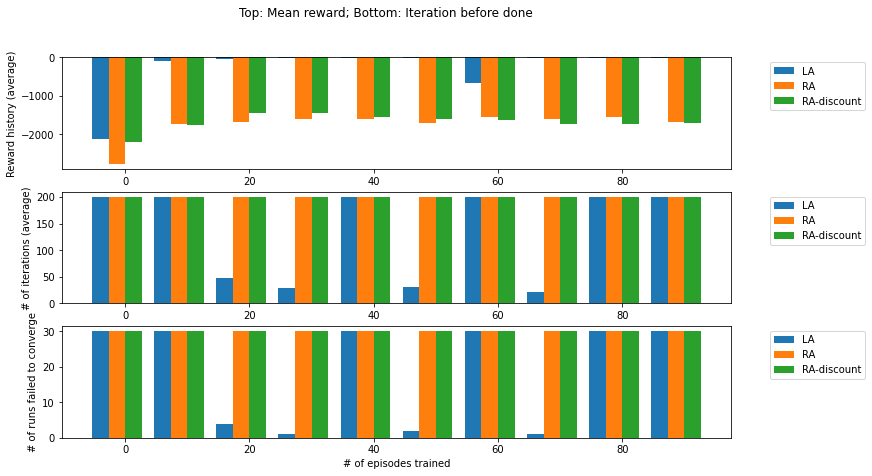

In [30]:
plot_reward_hist([a1hist, a2hist, a7hist], test_interval, 
                 ['LA','RA','RA-discount'], 
                 log=False, num_iteration=num_iteration)

In [ ]:
# Change the net.train() setting method by avoiding a function call
# Move the batch training step inside each iteration
reload(utils.networks)
reload(utils.agents)
reload(utils.train_test_methods)
from utils.networks import *
from utils.agents import *
from utils.train_test_methods import *

agent1 = LearnerAgent(device, N, env.no, env.na, hidden)
a1hist = train(agent1, env, num_episode, test_interval, num_test, num_iteration, BATCH_SIZE, num_sample, 
               action_space, debug)

agent2 = RewardAgent(device, N, env.no, env.na, hidden)
a2hist = train(agent2, env, num_episode, test_interval, num_test, num_iteration, BATCH_SIZE, num_sample, 
               action_space, debug)

agent7 = RewardAgent(device, N, env.no, env.na, hidden)
a7hist = train(agent7, env, num_episode, test_interval, num_test, num_iteration, BATCH_SIZE, num_sample, 
               action_space, debug=debug, reward_mode=FUTURE_REWARD_YES)


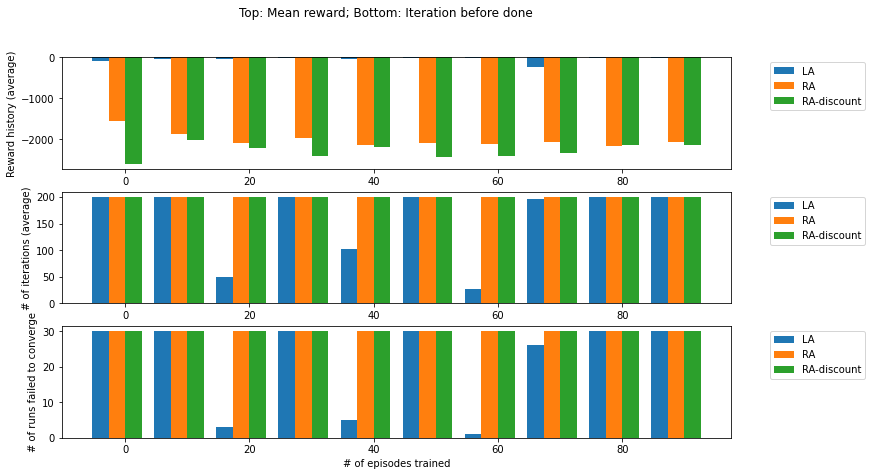

In [32]:
plot_reward_hist([a1hist, a2hist, a7hist], test_interval, 
                 ['LA','RA','RA-discount'], 
                 log=False, num_iteration=num_iteration)

In [ ]:
# Change the net.train() setting method by avoiding a function call
# Move the batch training step inside each iteration
# Use the old network definitions
reload(utils.networks)
reload(utils.agents)
reload(utils.train_test_methods)
from utils.networks import *
from utils.agents import *
from utils.train_test_methods import *

agent1 = LearnerAgent(device, N, env.no, env.na, hidden)
a1hist = train(agent1, env, num_episode, test_interval, num_test, num_iteration, BATCH_SIZE, num_sample, 
               action_space, debug)

agent2 = RewardAgent(device, N, env.no, env.na, hidden)
a2hist = train(agent2, env, num_episode, test_interval, num_test, num_iteration, BATCH_SIZE, num_sample, 
               action_space, debug)

agent7 = RewardAgent(device, N, env.no, env.na, hidden)
a7hist = train(agent7, env, num_episode, test_interval, num_test, num_iteration, BATCH_SIZE, num_sample, 
               action_space, debug=debug, reward_mode=FUTURE_REWARD_YES)


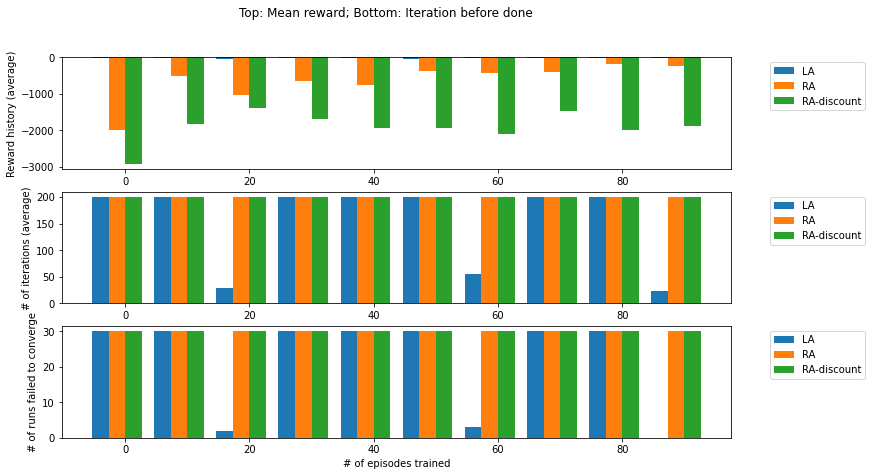

In [36]:
plot_reward_hist([a1hist, a2hist, a7hist], test_interval, 
                 ['LA','RA','RA-discount'], 
                 log=False, num_iteration=num_iteration)

In [ ]:
# Change the net.train() setting method by avoiding a function call
# Move the batch training step back outside
# Use the old network definitions
reload(utils.networks)
reload(utils.agents)
reload(utils.train_test_methods)
from utils.networks import *
from utils.agents import *
from utils.train_test_methods import *

agent1 = LearnerAgent(device, N, env.no, env.na, hidden)
a1hist = train(agent1, env, num_episode, test_interval, num_test, num_iteration, BATCH_SIZE, num_sample, 
               action_space, debug)

agent2 = RewardAgent(device, N, env.no, env.na, hidden)
a2hist = train(agent2, env, num_episode, test_interval, num_test, num_iteration, BATCH_SIZE, num_sample, 
               action_space, debug)

agent7 = RewardAgent(device, N, env.no, env.na, hidden)
a7hist = train(agent7, env, num_episode, test_interval, num_test, num_iteration, BATCH_SIZE, num_sample, 
               action_space, debug=debug, reward_mode=FUTURE_REWARD_YES)


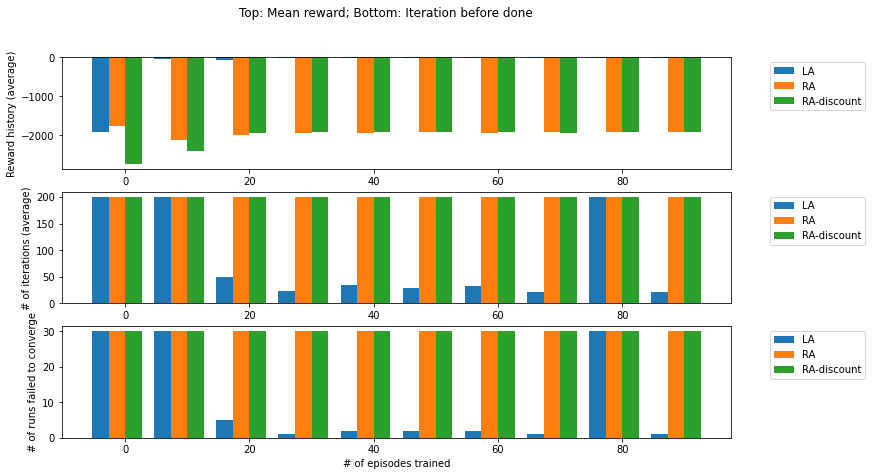

In [38]:
plot_reward_hist([a1hist, a2hist, a7hist], test_interval, 
                 ['LA','RA','RA-discount'], 
                 log=False, num_iteration=num_iteration)

In [ ]:
# Revert to using the net.train() setting method again
# Move the batch training step back inside iterations
# Use the old network definitions
reload(utils.networks)
reload(utils.agents)
reload(utils.train_test_methods)
from utils.networks import *
from utils.agents import *
from utils.train_test_methods import *

agent1 = LearnerAgent(device, N, env.no, env.na, hidden)
a1hist = train(agent1, env, num_episode, test_interval, num_test, num_iteration, BATCH_SIZE, num_sample, 
               action_space, debug)

agent2 = RewardAgent(device, N, env.no, env.na, hidden)
a2hist = train(agent2, env, num_episode, test_interval, num_test, num_iteration, BATCH_SIZE, num_sample, 
               action_space, debug)

agent7 = RewardAgent(device, N, env.no, env.na, hidden)
a7hist = train(agent7, env, num_episode, test_interval, num_test, num_iteration, BATCH_SIZE, num_sample, 
               action_space, debug=debug, reward_mode=FUTURE_REWARD_YES)

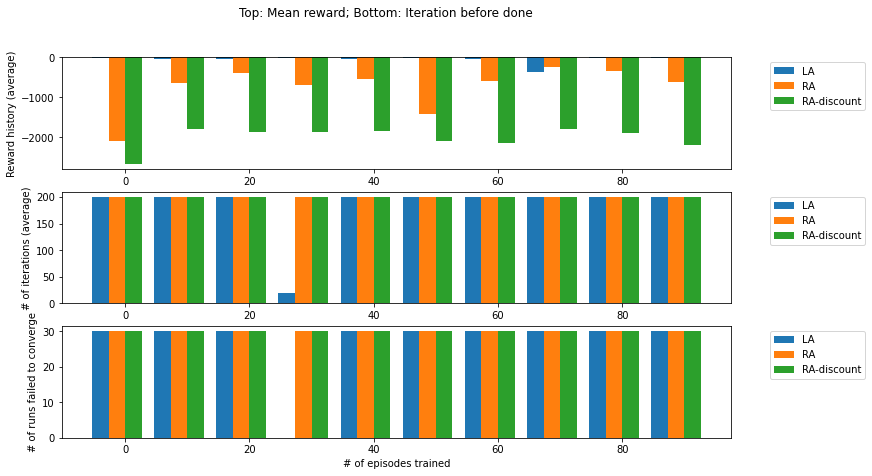

In [40]:
plot_reward_hist([a1hist, a2hist, a7hist], test_interval, 
                 ['LA','RA','RA-discount'], 
                 log=False, num_iteration=num_iteration)

In [ ]:
# Revert to using the net.train() setting method again
# Move the batch training step outside iterations, but increase training amount
# Use the old network definitions
reload(utils.networks)
reload(utils.agents)
reload(utils.train_test_methods)
from utils.networks import *
from utils.agents import *
from utils.train_test_methods import *

# agent1 = LearnerAgent(device, N, env.no, env.na, hidden)
# a1hist = train(agent1, env, num_episode, test_interval, num_test, num_iteration, BATCH_SIZE, num_sample, 
#                action_space, debug)
N=10
agent2 = RewardAgent(device, N, env.no, env.na, hidden)
a2hist = train(agent2, env, num_episode, test_interval, num_test, num_iteration, BATCH_SIZE*4, num_sample, 
               action_space, debug)

# agent7 = RewardAgent(device, N, env.no, env.na, hidden)
# a7hist = train(agent7, env, num_episode, test_interval, num_test, num_iteration, BATCH_SIZE*4, num_sample, 
#                action_space, debug=debug, reward_mode=FUTURE_REWARD_YES)

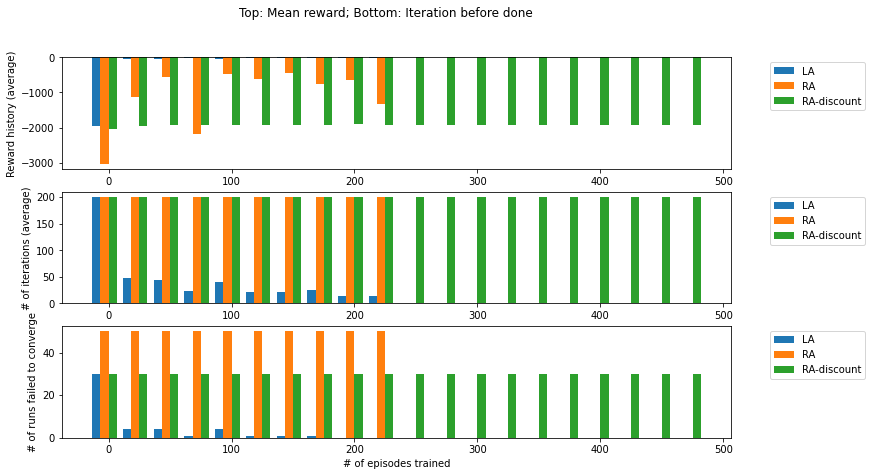

In [61]:
# a2hist += train(agent2, env, num_episode, test_interval, num_test, num_iteration, BATCH_SIZE*4, num_sample, 
#                action_space, debug)
# a7hist += train(agent7, env, num_episode, test_interval, num_test, num_iteration, BATCH_SIZE*4, num_sample, 
#                action_space, debug)
plot_reward_hist([a1hist, a2hist, a7hist], test_interval, 
                 ['LA','RA','RA-discount'], 
                 log=False, num_iteration=num_iteration)

Test result at episode  0 : 
[11670944 22851341 10552915 13809098 24555918 15079090 14325343 23364668
 16339895 10500288 21806113 28963676  3195980  5124537 21684480 27241941
 22214581 11942504  6678488 11761867 28256092 20032965 22314105 12578549
 22325054 11040014 10526721    20057 28818431 26177918  6343697 25840821
 26960842 19284645 23850149 26106426 29453823 24683498 29858540 10862315
  1947615 21103977 24768013  3670832 28661599 25995140  8296426 14124755
 18612453  6946400]
Finished test  0  with  199 ; cumulative reward =  -16645.61170757172
Finished test  1  with  199 ; cumulative reward =  -18894.875499520815
Finished test  2  with  199 ; cumulative reward =  -15366.225639925131
Finished test  3  with  199 ; cumulative reward =  -18348.554150064956
Finished test  4  with  199 ; cumulative reward =  -16634.68270133517
Finished test  5  with  199 ; cumulative reward =  -16468.95356682074
Finished test  6  with  199 ; cumulative reward =  -16716.10574513186
Finished test  7  wi

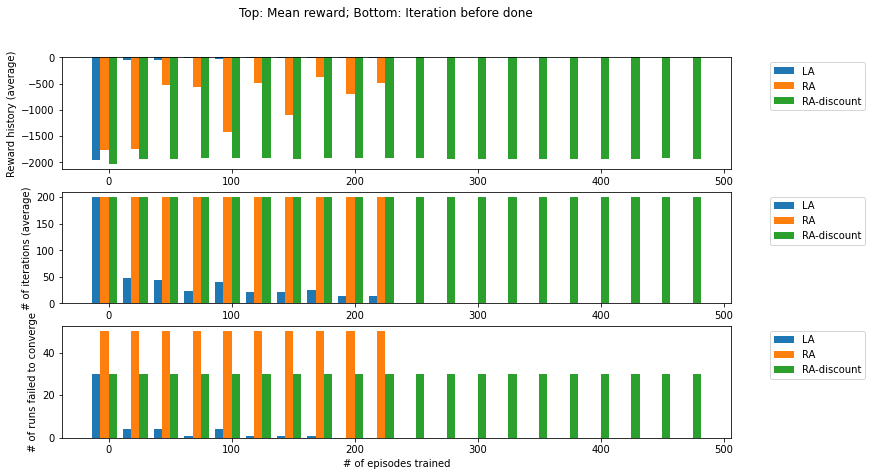

In [106]:
# Revert to using the net.train() setting method again
# Move the batch training step inside iterations
# Use the updated network definitions
reload(utils.networks)
reload(utils.agents)
reload(utils.train_test_methods)
from utils.networks import *
from utils.agents import *
from utils.train_test_methods import *

# agent1 = LearnerAgent(device, N, env.no, env.na, hidden)
# a1hist = train(agent1, env, num_episode, test_interval, num_test, num_iteration, BATCH_SIZE, num_sample, 
#                action_space, debug)

agent2 = RewardAgent(device, N, env.no, env.na, hidden)
a2hist = train(agent2, env, num_episode, test_interval, num_test, num_iteration, BATCH_SIZE, num_sample, 
               action_space, debug)

# agent7 = RewardAgent(device, N, env.no, env.na, hidden)
# a7hist = train(agent7, env, num_episode, test_interval, num_test, num_iteration, BATCH_SIZE*4, num_sample, 
#                action_space, debug=debug, reward_mode=FUTURE_REWARD_YES)

# a2hist += train(agent2, env, num_episode, test_interval, num_test, num_iteration, BATCH_SIZE*4, num_sample, 
#                action_space, debug)
# a7hist += train(agent7, env, num_episode, test_interval, num_test, num_iteration, BATCH_SIZE*4, num_sample, 
#                action_space, debug)
plot_reward_hist([a1hist, a2hist, a7hist], test_interval, 
                 ['LA','RA','RA-discount'], 
                 log=False, num_iteration=num_iteration)

In [75]:
agent2.net.parameters

<bound method Module.parameters of RewardNet(
  (FTlayers): ModuleList(
    (0): Flatten()
    (1): Flatten()
  )
  (RNlayers): ModuleList(
    (0): Linear(in_features=42, out_features=32, bias=True)
    (1): Linear(in_features=32, out_features=32, bias=True)
    (2): Linear(in_features=32, out_features=1, bias=True)
  )
)>

In [86]:
for ppp in agent2.net.named_parameters():
    print(ppp)
#     print(np.prod(ppp.data.shape),ppp.data.shape)
#     print(ppp,ppp.requires_grad)

('RNlayers.0.weight', Parameter containing:
tensor([[-0.0543,  0.0738, -0.3724,  ..., -0.0277, -0.0137, -0.1108],
        [ 0.0909,  0.2863,  0.0319,  ...,  0.1569,  0.1683, -0.1400],
        [-0.0334, -0.0435,  0.0756,  ..., -0.0930, -0.0324, -0.0932],
        ...,
        [-0.2704, -0.0309,  0.0623,  ...,  0.1446,  0.0720, -0.0066],
        [ 0.1005,  0.0135,  0.2204,  ...,  0.2467,  0.0841, -0.2103],
        [-0.1408, -0.1571, -0.0267,  ...,  0.1324,  0.0513,  0.0694]],
       requires_grad=True))
('RNlayers.0.bias', Parameter containing:
tensor([ 0.3431,  0.0923, -0.1920,  0.2273,  0.2546,  0.3516,  0.1631,  0.3012,
        -0.2053,  0.1466,  0.4038,  0.3055,  0.2949,  0.4753,  0.3512,  0.0335,
         0.4557,  0.3196,  0.1427, -0.1139, -0.0177,  0.2375,  0.1313,  0.0190,
         0.3890,  0.3812,  0.4183,  0.1883,  0.5118,  0.3043, -0.2345,  0.3855],
       requires_grad=True))
('RNlayers.1.weight', Parameter containing:
tensor([[ 0.9280,  0.6733,  0.8463,  ...,  0.5804,  0.5609,

In [87]:
for ppp in agent2.net.parameters():
    print(np.prod(ppp.data.shape),ppp.data.shape) # Prints weights and bias
    print(ppp,ppp.requires_grad)

1344 torch.Size([32, 42])
Parameter containing:
tensor([[-0.0543,  0.0738, -0.3724,  ..., -0.0277, -0.0137, -0.1108],
        [ 0.0909,  0.2863,  0.0319,  ...,  0.1569,  0.1683, -0.1400],
        [-0.0334, -0.0435,  0.0756,  ..., -0.0930, -0.0324, -0.0932],
        ...,
        [-0.2704, -0.0309,  0.0623,  ...,  0.1446,  0.0720, -0.0066],
        [ 0.1005,  0.0135,  0.2204,  ...,  0.2467,  0.0841, -0.2103],
        [-0.1408, -0.1571, -0.0267,  ...,  0.1324,  0.0513,  0.0694]],
       requires_grad=True) True
32 torch.Size([32])
Parameter containing:
tensor([ 0.3431,  0.0923, -0.1920,  0.2273,  0.2546,  0.3516,  0.1631,  0.3012,
        -0.2053,  0.1466,  0.4038,  0.3055,  0.2949,  0.4753,  0.3512,  0.0335,
         0.4557,  0.3196,  0.1427, -0.1139, -0.0177,  0.2375,  0.1313,  0.0190,
         0.3890,  0.3812,  0.4183,  0.1883,  0.5118,  0.3043, -0.2345,  0.3855],
       requires_grad=True) True
1024 torch.Size([32, 32])
Parameter containing:
tensor([[ 0.9280,  0.6733,  0.8463,  ...,  

In [105]:
reload(utils.networks)
reload(utils.agents)
reload(utils.train_test_methods)
from utils.networks import *
from utils.agents import *
from utils.train_test_methods import *

agent2 = RewardAgent(device, N, env.no, env.na, hidden)
a2hist = train(agent2, env, 2, 5, 0, num_iteration, BATCH_SIZE, num_sample, 
               action_space, debug)


Last layer gradients after backward: 
tensor([[-0.0146,  0.0021,  0.0130,  ...,  0.0602,  0.0472,  0.0377],
        [-0.0529, -0.0151,  0.0096,  ...,  0.0105,  0.1179,  0.0505],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        ...,
        [-0.0029,  0.0015,  0.0044,  ...,  0.0062,  0.0137,  0.0086],
        [-0.0960, -0.0202,  0.0294,  ...,  0.0568,  0.2356,  0.0787],
        [-0.0772, -0.0117,  0.0312,  ...,  0.0531,  0.1991,  0.1388]])
Last layer gradients after backward: 
tensor([[ 0.0000,  0.0355, -0.0048,  ...,  0.0000,  0.2100, -0.0847],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        ...,
        [ 0.0228,  0.0135,  0.0097,  ...,  0.0117,  0.1746, -0.1556],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0113,  0.0097,  0.0032,  ...,  0.0055,  0.1996, -0.1192]])
Last layer gradients after backward: 
tensor([[-4.7411e-

In [ ]:
# Change the net.train() setting method by avoiding a function call
# Move the batch training step inside each iteration
# Use the old network definitions
# Put memory size back to 10000
reload(utils.networks)
reload(utils.agents)
reload(utils.train_test_methods)
from utils.networks import *
from utils.agents import *
from utils.train_test_methods import *

agent1 = LearnerAgent(device, N, env.no, env.na, hidden)
a1hist = train(agent1, env, num_episode, test_interval, num_test, num_iteration, BATCH_SIZE, num_sample, 
               action_space, debug)

agent2 = RewardAgent(device, N, env.no, env.na, hidden)
a2hist = train(agent2, env, num_episode, test_interval, num_test, num_iteration, BATCH_SIZE, num_sample, 
               action_space, debug)

agent7 = RewardAgent(device, N, env.no, env.na, hidden)
a7hist = train(agent7, env, num_episode, test_interval, num_test, num_iteration, BATCH_SIZE, num_sample, 
               action_space, debug=debug, reward_mode=FUTURE_REWARD_YES)

plot_reward_hist([a1hist, a2hist, a7hist], test_interval, 
                 ['LA','RA','RA-discount'], 
                 log=False, num_iteration=num_iteration)

In [ ]:
# Change the net.train() setting method by avoiding a function call
# Move the batch training step inside each iteration
# Use the old network definitions
# Put memory size back to 10000
# Start rendering environment sporadically
reload(utils.networks)
reload(utils.agents)
reload(utils.train_test_methods)
from utils.networks import *
from utils.agents import *
from utils.train_test_methods import *

agent1 = LearnerAgent(device, N, env.no, env.na, hidden)
a1hist = train(agent1, env, num_episode, test_interval, num_test, num_iteration, BATCH_SIZE, num_sample, 
               action_space, debug)

agent2 = RewardAgent(device, N, env.no, env.na, hidden)
a2hist = train(agent2, env, num_episode, test_interval, num_test, num_iteration, BATCH_SIZE, num_sample, 
               action_space, debug)

agent7 = RewardAgent(device, N, env.no, env.na, hidden)
a7hist = train(agent7, env, num_episode, test_interval, num_test, num_iteration, BATCH_SIZE, num_sample, 
               action_space, debug=debug, reward_mode=FUTURE_REWARD_YES)

plot_reward_hist([a1hist, a2hist, a7hist], test_interval, 
                 ['LA','RA','RA-discount'], 
                 log=False, num_iteration=num_iteration)

In [ ]:
# Change the net.train() setting method by avoiding a function call
# Move the batch training step inside each iteration
# Use the old network definitions
# Put memory size back to 10000
# Start rendering environment sporadically
# Print out loss values per step
reload(utils.networks)
reload(utils.agents)
reload(utils.train_test_methods)
from utils.networks import *
from utils.agents import *
from utils.train_test_methods import *

agent1 = LearnerAgent(device, N, env.no, env.na, hidden)
a1hist = train(agent1, env, num_episode, test_interval, num_test, num_iteration, BATCH_SIZE, num_sample, 
               action_space, debug)

agent2 = RewardAgent(device, N, env.no, env.na, hidden)
a2hist = train(agent2, env, num_episode, test_interval, num_test, num_iteration, BATCH_SIZE, num_sample, 
               action_space, debug)

agent7 = RewardAgent(device, N, env.no, env.na, hidden)
a7hist = train(agent7, env, num_episode, test_interval, num_test, num_iteration, BATCH_SIZE, num_sample, 
               action_space, debug=debug, reward_mode=FUTURE_REWARD_YES)

plot_reward_hist([a1hist, a2hist, a7hist], test_interval, 
                 ['LA','RA','RA-discount'], 
                 log=False, num_iteration=num_iteration)